# Arrow Segmentation Notebook



In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

project_path = '/content/drive/MyDrive/raivn/'

Mounted at /content/drive


In [2]:
!nvidia-smi

Wed Jan 28 09:44:46 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   38C    P0             57W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
!pip install numpy torch torchvision torchaudio pillow opencv-python ultralytics transformers huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ultralytics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.

In [29]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
import random
from ultralytics import YOLO
from transformers import Sam3Processor, Sam3Model
from huggingface_hub import login, hf_hub_download

# Authenticate with Hugging Face
login()

### Detect Arrows, Tips, and Tails Prior to Segmentation

In [6]:
# Define the path to the saved model in Google Drive
model_path = os.path.join(project_path, 'arrow-detector-v2-medium.pt')

# Load the trained model
loaded_model = YOLO(model_path)

print(f"Model loaded successfully from: {model_path}")

Model loaded successfully from: /content/drive/MyDrive/raivn/arrow-detector-v2-medium.pt



image 1/1 /content/drive/MyDrive/raivn/manual-tests/pic5.jpeg: 640x512 3 arrows, 88.5ms
Speed: 2.9ms preprocess, 88.5ms inference, 19.2ms postprocess per image at shape (1, 3, 640, 512)


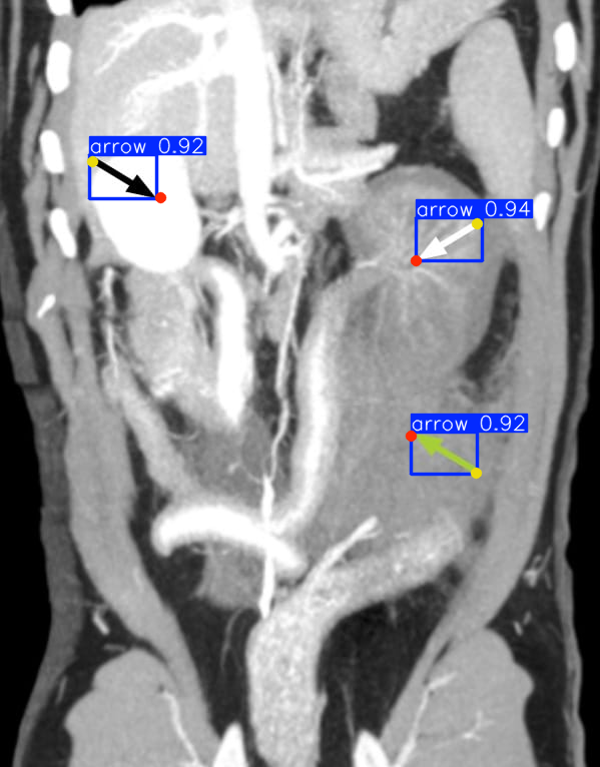

Bounding Boxes:
Arrow 1:  [[415.3933410644531, 217.8406524658203, 481.16265869140625, 260.34356689453125]]
Arrow 2:  [[410.5718688964844, 431.37890625, 476.68182373046875, 473.9494934082031]]
Arrow 3:  [[89.31277465820312, 154.48866271972656, 156.4512176513672, 198.9029998779297]]

Keypoints:
========== Arrow 1 ==========
Tip at [415.20721435546875, 260.343994140625]
Tail at [476.32470703125, 223.18295288085938]
Direction (degrees): -148.699299644624
========== Arrow 2 ==========
Tip at [410.8832092285156, 435.0995178222656]
Tail at [475.04931640625, 472.79388427734375]
Direction (degrees): 149.5679027672697
========== Arrow 3 ==========
Tip at [160.4475555419922, 197.07557678222656]
Tail at [92.52911376953125, 161.12164306640625]
Direction (degrees): -27.895367780841696


In [7]:
def get_arrow_direction(tip_point, tail_point):
    """
    Calculates the direction (angle in radians) of an arrow given its tip and tail points.
    """
    dx = tip_point[0] - tail_point[0]
    dy = (-tip_point[1]) - (-tail_point[1])  # negate bc y-values increase as you go down an image

    angle_radians = math.atan2(dy, dx)
    return math.degrees(angle_radians)

# Define the path to an example image in manual_tests
image_path = os.path.join(project_path, 'manual-tests/pic5.jpeg')

# Perform inference on the image
results = loaded_model(image_path)

# Display the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image

    # Resize the image to a constant width for display
    target_width = 600
    original_width, original_height = im.size
    new_height = int((target_width / original_width) * original_height)
    im_resized = im.resize((target_width, new_height))

    display(im_resized)  # display resized image

    # Print bounding boxes and keypoints
    if r.boxes is not None and len(r.boxes) > 0:
        print("Bounding Boxes:")
        for i, box in enumerate(r.boxes):
            print(f"Arrow {i+1}:  {box.xyxy.tolist()}")

    if r.keypoints is not None and len(r.keypoints.xy) > 0:
        print("\nKeypoints:")
        for i, kpts in enumerate(r.keypoints.xy):
            points = kpts.tolist()
            print("="*10 + f" Arrow {i+1} " + "="*10)
            print(f"Tip at {points[0]}")
            print(f"Tail at {points[1]}")
            print(f"Direction (degrees): {get_arrow_direction(points[0], points[1])}")

In [ ]:
# Visualize YOLO detections in order with bounding boxes
result = results[0]
image_with_boxes = np.array(Image.open(image_path).convert("RGB"))

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(image_with_boxes)

if result.boxes is not None and len(result.boxes) > 0:
    for i, box in enumerate(result.boxes.xyxy):
        x1, y1, x2, y2 = box.cpu().numpy()
        
        # Draw bounding box
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                            fill=False, edgecolor='lime', linewidth=3)
        ax.add_patch(rect)
        
        # Add label with index
        ax.text(x1, y1-10, f'YOLO {i}', 
               color='lime', fontsize=16, weight='bold',
               bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
        
        # Draw keypoints if available
        if result.keypoints is not None and i < len(result.keypoints.xy):
            kpts = result.keypoints.xy[i].cpu().numpy()
            tip = kpts[0]
            tail = kpts[1]
            
            # Draw tip and tail
            ax.plot(tip[0], tip[1], 'ro', markersize=10, label='Tip' if i == 0 else '')
            ax.plot(tail[0], tail[1], 'yo', markersize=10, label='Tail' if i == 0 else '')
            
            # Draw arrow direction line
            ax.arrow(tail[0], tail[1], tip[0]-tail[0], tip[1]-tail[1],
                    head_width=15, head_length=20, fc='cyan', ec='cyan', alpha=0.7)
        
        print(f"YOLO Detection {i}: BBox = [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

ax.set_title('YOLO Detections (in order)')
ax.axis('off')
if result.keypoints is not None:
    ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


### Use BBox to Help Prompt SAM

In [22]:
result = results[0]
input_boxes = [result.boxes.xyxy.tolist()]
print(f"Input Boxes for SAM: {input_boxes}")
input_labels = [[1 for _ in range(len(input_boxes[0]))]]
print(f"Positive Input Labels for SAM: {input_labels}")

Input Boxes for SAM: [[[415.3933410644531, 217.8406524658203, 481.16265869140625, 260.34356689453125], [410.5718688964844, 431.37890625, 476.68182373046875, 473.9494934082031], [89.31277465820312, 154.48866271972656, 156.4512176513672, 198.9029998779297]]]
Positive Input Labels for SAM: [[1, 1, 1]]


In [15]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

In [4]:
def show_masks_on_black(image, masks):
    plt.figure(figsize=(18, 9))

    # Plot Input Image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    # Plot Output Image (Masks on Black)
    plt.subplot(1, 2, 2)

    # Ensure image is numpy array
    if hasattr(image, "size"):
        image_np = np.array(image)
    else:
        image_np = image

    h, w = image_np.shape[:2]

    # Create black background canvas
    final_canvas = np.zeros_like(image_np)

    n_detections = len(masks)
    plt.title(f"Output Image ({n_detections} masks)")
    plt.axis("off")

    if n_detections > 0:
        # Convert to numpy if tensor
        if isinstance(masks, torch.Tensor):
            masks_np = masks.cpu().numpy()
        else:
            masks_np = np.array(masks)

        # Combine all masks into a single boolean mask
        combined_mask = np.zeros((h, w), dtype=bool)

        for mask in masks_np:
            if mask.ndim == 3:
                mask = mask.squeeze()

            # Ensure boolean and combine
            mask_bool = mask > 0
            combined_mask = np.logical_or(combined_mask, mask_bool)

        # Apply the original image pixels where the mask is active
        final_canvas[combined_mask] = image_np[combined_mask]

    plt.imshow(final_canvas)
    plt.show()

Found 3 instances of 'arrows'


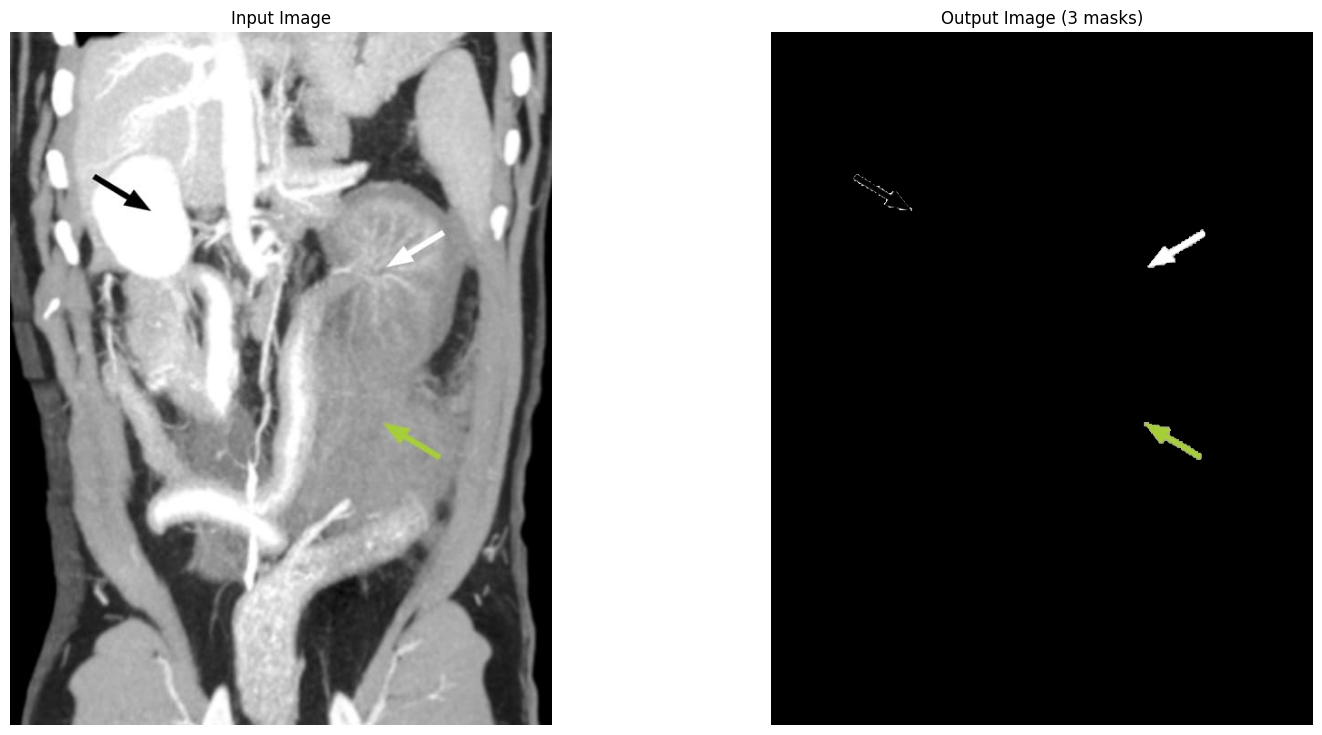

In [27]:
# Load an image
# Fix: os.join.join should be os.path.join
image_path = os.path.join(project_path, "manual-tests/pic5.jpeg") # Replace with your image path
image = Image.open(image_path).convert("RGB")

# Prepare image for inference
#inference_state = processor.set_image(image)

# Run segmentation with text and bbox prompt
prompt = "arrows"
inputs = processor(
    images=image,
    text=prompt,
    input_boxes=input_boxes,
    input_boxes_labels=input_labels,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  outputs = model(**inputs)

output = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

# Results include masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]
print(f"Found {len(masks)} instances of '{prompt}'")


# Display the results
show_masks_on_black(image, masks)

In [ ]:
# Display each SAM mask individually to see the order
fig, axes = plt.subplots(1, len(masks), figsize=(5*len(masks), 5))
if len(masks) == 1:
    axes = [axes]

for idx, (mask, box) in enumerate(zip(masks, boxes)):
    # Convert mask to numpy if needed
    if isinstance(mask, torch.Tensor):
        mask_np = mask.cpu().numpy()
    else:
        mask_np = np.array(mask)
    
    if mask_np.ndim == 3:
        mask_np = mask_np.squeeze()
    
    # Display mask
    axes[idx].imshow(mask_np, cmap='gray')
    axes[idx].set_title(f'SAM Mask {idx}')
    axes[idx].axis('off')
    
    # Print box coordinates
    if isinstance(box, torch.Tensor):
        box_coords = box.cpu().numpy()
    else:
        box_coords = box
    print(f"SAM Mask {idx}: BBox = [{box_coords[0]:.1f}, {box_coords[1]:.1f}, {box_coords[2]:.1f}, {box_coords[3]:.1f}]")

plt.tight_layout()
plt.show()


In [ ]:
# Check if SAM is reordering by score or other factors
print("SAM Output Order Analysis:")
print("="*50)
for idx in range(len(masks)):
    if isinstance(boxes[idx], torch.Tensor):
        box_coords = boxes[idx].cpu().numpy()
    else:
        box_coords = boxes[idx]
    
    if isinstance(scores[idx], torch.Tensor):
        score = scores[idx].cpu().item()
    else:
        score = scores[idx]
    
    print(f"SAM Mask {idx}: Score={score:.4f}, BBox=[{box_coords[0]:.1f}, {box_coords[1]:.1f}, {box_coords[2]:.1f}, {box_coords[3]:.1f}]")

print("\n" + "="*50)
print("Comparing to YOLO input boxes order:")
print("="*50)
for idx in range(len(result.boxes.xyxy)):
    yolo_box = result.boxes.xyxy[idx].cpu().numpy()
    print(f"YOLO Detection {idx}: BBox=[{yolo_box[0]:.1f}, {yolo_box[1]:.1f}, {yolo_box[2]:.1f}, {yolo_box[3]:.1f}]")


### Use YOLO Tip and Tail Points to Have Arrow Point To The Right

In [ ]:
def rotate_arrow(image, tip, tail, target_angle=0, debug=False):
    """
    Rotate an arrow image so it points in the target direction.
    
    Parameters:
    -----------
    image : PIL.Image or np.ndarray
        RGBA image with the arrow
    tip : tuple
        (x, y) coordinates of arrow tip
    tail : tuple
        (x, y) coordinates of arrow tail
    target_angle : float
        Target angle in degrees (0 = right, 90 = up, 180 = left, -90 = down)
    debug : bool
        If True, print rotation details
    
    Returns:
    --------
    rotated_image : PIL.Image
        Rotated RGBA image
    """
    # Convert to PIL if needed
    if isinstance(image, np.ndarray):
        image = Image.fromarray(image)
    
    # Calculate current angle
    # dx and dy represent the vector from tail to tip
    dx = tip[0] - tail[0]
    dy = -(tip[1] - tail[1])  # Negate because y increases downward in image coords
    current_angle = math.degrees(math.atan2(dy, dx))
    
    # Calculate rotation needed to reach target angle
    # PIL rotates counter-clockwise, so negative angles rotate clockwise
    rotation_needed = target_angle - current_angle
    
    if debug:
        print(f"Tip: {tip}, Tail: {tail}")
        print(f"Current angle: {current_angle:.1f}°")
        print(f"Target angle: {target_angle:.1f}°")
        print(f"Rotation needed: {rotation_needed:.1f}° ({'counter-clockwise' if rotation_needed > 0 else 'clockwise'})")
    
    # Rotate image around its center with expansion to prevent cropping
    rotated = image.rotate(rotation_needed, resample=Image.BICUBIC, expand=True)
    
    return rotated


In [ ]:
def match_sam_to_yolo(sam_boxes, yolo_boxes):
    """
    Match SAM output boxes to YOLO input boxes using IoU.
    Returns a list mapping SAM index to YOLO index.
    """
    def compute_iou(box1, box2):
        # box format: [x1, y1, x2, y2]
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        
        intersection = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union = area1 + area2 - intersection
        
        return intersection / union if union > 0 else 0
    
    # Convert to numpy if needed
    if isinstance(sam_boxes, torch.Tensor):
        sam_boxes = sam_boxes.cpu().numpy()
    if isinstance(yolo_boxes, torch.Tensor):
        yolo_boxes = yolo_boxes.cpu().numpy()
    
    matches = []
    for sam_idx in range(len(sam_boxes)):
        best_iou = 0
        best_yolo_idx = 0
        
        for yolo_idx in range(len(yolo_boxes)):
            iou = compute_iou(sam_boxes[sam_idx], yolo_boxes[yolo_idx])
            if iou > best_iou:
                best_iou = iou
                best_yolo_idx = yolo_idx
        
        matches.append(best_yolo_idx)
        print(f"SAM Mask {sam_idx} → YOLO Detection {best_yolo_idx} (IoU: {best_iou:.4f})")
    
    return matches


In [ ]:
def save_individual_masks(image, masks, sam_boxes, yolo_result, output_dir="arrow_masks", debug=False):
    """
    Save individual arrow masks as rotated RGBA PNGs pointing to the right.
    
    Parameters:
    -----------
    image : PIL.Image or np.ndarray
        Original image
    masks : list
        SAM segmentation masks
    sam_boxes : list
        Bounding boxes from SAM
    yolo_result : YOLO result object
        Contains keypoints (tip and tail) and bounding boxes for each arrow
    output_dir : str
        Directory to save the arrow PNGs
    debug : bool
        If True, print rotation details for each arrow
    
    Returns:
    --------
    saved_paths : list
        Paths to saved PNG files
    """
    output_dir = os.path.join(project_path, output_dir)
    os.makedirs(output_dir, exist_ok=True)

    # Ensure image is numpy array
    if isinstance(image, Image.Image):
        image_np = np.array(image)
    else:
        image_np = image

    h, w = image_np.shape[:2]

    # Get keypoints from YOLO result
    if yolo_result.keypoints is None or len(yolo_result.keypoints.xy) == 0:
        print("Warning: No keypoints found in YOLO result. Cannot rotate arrows.")
        return []
    
    keypoints = yolo_result.keypoints.xy
    yolo_boxes = yolo_result.boxes.xyxy
    
    # Match SAM masks to YOLO detections
    print("\nMatching SAM masks to YOLO detections:")
    matches = match_sam_to_yolo(sam_boxes, yolo_boxes)
    print()

    saved_paths = []

    # Iterate through masks and boxes
    for sam_idx, (mask, box) in enumerate(zip(masks, sam_boxes)):
        yolo_idx = matches[sam_idx]
        
        if debug:
            print(f"\n--- Processing SAM Mask {sam_idx} (matched to YOLO {yolo_idx}) ---")
        
        # Convert mask to numpy if it's a tensor
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()

        # Squeeze if needed (1, H, W) -> (H, W)
        if mask.ndim == 3:
            mask = mask.squeeze()

        # Create boolean mask
        mask_bool = mask > 0

        # Create RGBA image (H, W, 4)
        rgba_image = np.zeros((h, w, 4), dtype=np.uint8)
        rgba_image[..., :3] = image_np  # RGB channels
        rgba_image[..., 3] = (mask_bool * 255).astype(np.uint8) # Alpha channel

        # Convert to PIL for cropping
        pil_image = Image.fromarray(rgba_image)

        # Crop using bounding box
        if isinstance(box, torch.Tensor):
            box = box.cpu().numpy()

        # Box is usually [x1, y1, x2, y2]
        x1, y1, x2, y2 = map(int, box)

        # Clamp coordinates to image boundaries
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        # Crop
        cropped_arrow = pil_image.crop((x1, y1, x2, y2))
        
        # Get keypoints from matched YOLO detection
        kpts = keypoints[yolo_idx].tolist()
        tip_point = kpts[0]
        tail_point = kpts[1]
        
        if debug:
            print(f"  Using keypoints from YOLO detection {yolo_idx}")
            print(f"  Tip (global): {tip_point}, Tail (global): {tail_point}")
        
        # Adjust tip and tail points to be relative to cropped image
        tip_relative = (tip_point[0] - x1, tip_point[1] - y1)
        tail_relative = (tail_point[0] - x1, tail_point[1] - y1)
        
        # Rotate arrow to point right (0 degrees)
        cropped_arrow = rotate_arrow(cropped_arrow, tip_relative, tail_relative, target_angle=0, debug=debug)
        
        # Crop tightly around non-transparent pixels after rotation
        arrow_array = np.array(cropped_arrow)
        alpha_channel = arrow_array[:, :, 3]
        
        # Find bounding box of non-transparent pixels
        rows = np.any(alpha_channel > 0, axis=1)
        cols = np.any(alpha_channel > 0, axis=0)
        
        if np.any(rows) and np.any(cols):
            y_min, y_max = np.where(rows)[0][[0, -1]]
            x_min, x_max = np.where(cols)[0][[0, -1]]
            
            # Crop to tight bounding box
            cropped_arrow = cropped_arrow.crop((x_min, y_min, x_max + 1, y_max + 1))
            
            if debug:
                print(f"  Cropped to tight bounds: ({x_max + 1 - x_min}x{y_max + 1 - y_min})")
        
        # Resize to width of 560 pixels while preserving aspect ratio
        arrow_w, arrow_h = cropped_arrow.size
        if arrow_w > 0:
            new_h = int(560 * arrow_h / arrow_w)
            cropped_arrow = cropped_arrow.resize((560, new_h), Image.BICUBIC)
            if debug:
                print(f"  Resized to 560x{new_h}")

        # Save
        filename = f"arrow_{sam_idx+1}.png"
        save_path = os.path.join(output_dir, filename)
        cropped_arrow.save(save_path)
        saved_paths.append(save_path)
        print(f"Saved: {save_path}")

    return saved_paths


Saved: /content/drive/MyDrive/raivn/arrow_masks/arrow_1.png
Saved: /content/drive/MyDrive/raivn/arrow_masks/arrow_2.png
Saved: /content/drive/MyDrive/raivn/arrow_masks/arrow_3.png
Displaying /content/drive/MyDrive/raivn/arrow_masks/arrow_1.png:


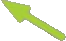

In [ ]:
# Run the function using the variables from the previous cells
# Pass the YOLO result to get keypoints for rotation
# Set debug=True to see rotation details
saved_files = save_individual_masks(image, masks, boxes, result, debug=True)

# Display the first one as an example
if saved_files:
    print(f"\nDisplaying {saved_files[0]}:")
    display(Image.open(saved_files[0]))
